<a href="https://colab.research.google.com/github/queenkatherinecodes/Best-README-Template/blob/master/Copy_of_KatherineBergerNLPFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prerequisites: Installation and Set-up to Access the Welfake Dataset for Fake News Classification

Reference: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import re
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/WELFake_Dataset.csv.zip', 'r') as z:
    df = pd.read_csv(z.open(z.namelist()[0]))

print("Dataset loaded:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset loaded:
Shape: (72134, 4)
Columns: ['Unnamed: 0', 'title', 'text', 'label']


In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
df = df.dropna(subset=['text']).copy()
df['title'] = df['title'].fillna('')
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-letters
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

df['content'] = (df['title'] + ' ' + df['text']).apply(clean_text)

print(f"After cleaning: {df.shape}")

After cleaning: (72095, 4)


<Axes: ylabel='count'>

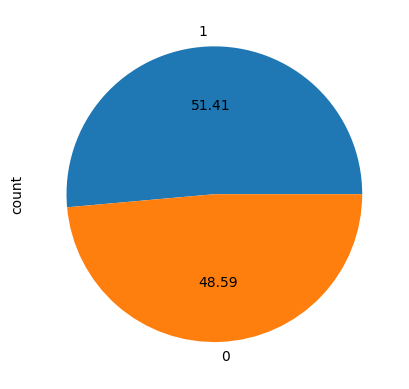

In [ ]:
df['label'].value_counts().plot.pie(autopct='%.2f')

Set Train/Test Split

In [ ]:
df = df.sample(n=10000, random_state=42)  # 10K samples - good balance
print(f"Using sample of: {df.shape}")

# 2. Then your train-test split
X = df['content'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Using sample of: (10000, 4)
Train: 8000, Test: 2000


In [ ]:
class WELFakeDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=256,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
print("Loading DistilRoBERTa model...")
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
model = AutoModelForSequenceClassification.from_pretrained('distilroberta-base', num_labels=2)

# Create Datasets
train_dataset = WELFakeDataset(X_train, y_train, tokenizer)
test_dataset = WELFakeDataset(X_test, y_test, tokenizer)

print(f"DistilRoBERTa loaded with {sum(p.numel() for p in model.parameters()):,} parameters")
print("(~35% smaller than regular RoBERTa)")

Loading DistilRoBERTa model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilRoBERTa loaded with 82,119,938 parameters
(~35% smaller than regular RoBERTa)


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,  # Increased from 16 to 32
    per_device_eval_batch_size=32,   # Increased for faster evaluation
    eval_strategy="epoch",
    logging_steps=25,  # Reduced logging frequency
    save_steps=500,
    report_to=[],
    dataloader_num_workers=2,  # Add parallel data loading
    fp16=True,  # Enable mixed precision training (faster on modern GPUs)
    gradient_accumulation_steps=1,
    warmup_steps=50,
)

# Metrics Function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Cell 9: Create and Train Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Train the Model
print("Starting training...")
trainer.train()

Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.159000,0.079690,0.974000
2,0.038800,0.107056,0.980000
3,0.029400,0.115955,0.979500


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

TrainOutput(global_step=1500, training_loss=0.09913701514403025, metrics={'train_runtime': 290.8041, 'train_samples_per_second': 82.53, 'train_steps_per_second': 5.158, 'total_flos': 1589608783872000.0, 'train_loss': 0.09913701514403025, 'epoch': 3.0})

In [ ]:
print("Evaluating on test set...")
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Save Model for October 7th Project
model.save_pretrained('/content/drive/MyDrive/october7_baseline_roberta')
tokenizer.save_pretrained('/content/drive/MyDrive/october7_baseline_roberta')

print("\n✅ Baseline model saved to Google Drive!")
print("Ready for October 7th misinformation detection project!")

Evaluating on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Test Accuracy: 0.9795

Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98       965
        Real       0.98      0.98      0.98      1035

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


✅ Baseline model saved to Google Drive!
Ready for October 7th misinformation detection project!


In [ ]:
print("Loading October 7th dataset...")
oct7_df = pd.read_csv('/content/drive/MyDrive/october_7_train.csv')

# Clean and prepare the data (same cleaning function you used before)
oct7_df = oct7_df.dropna(subset=['text']).copy()
oct7_df['title'] = oct7_df['title'].fillna('')
oct7_df['content'] = (oct7_df['title'] + ' ' + oct7_df['text']).apply(clean_text)

print(f"October 7th dataset shape: {oct7_df.shape}")
print(f"Label distribution:\n{oct7_df['label'].value_counts()}")

# Use ALL data for training (since you have separate test data)
X_oct7 = oct7_df['content'].values
y_oct7 = oct7_df['label'].values

Loading October 7th dataset...
October 7th dataset shape: (99, 5)
Label distribution:
label
0    50
1    49
Name: count, dtype: int64


In [ ]:
print("Loading baseline model...")
baseline_tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/october7_baseline_roberta')
baseline_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/october7_baseline_roberta')

print("✅ Baseline model loaded successfully!")

Loading baseline model...
✅ Baseline model loaded successfully!


In [ ]:
# Create dataset for fine-tuning
train_dataset_oct7 = WELFakeDataset(X_oct7, y_oct7, baseline_tokenizer)

# Fine-tuning arguments
training_args = TrainingArguments(
    output_dir='./results_oct7',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_steps=10,
    save_steps=100,
    learning_rate=2e-5,  # Lower learning rate for fine-tuning
    weight_decay=0.01,
    warmup_steps=20,
    report_to=[],
    fp16=True,
)

# Create trainer
trainer = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=train_dataset_oct7,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
print("Starting October 7th fine-tuning...")
trainer.train()

print("✅ Fine-tuning complete!")

Starting October 7th fine-tuning...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
10,4.130400
20,3.299900


✅ Fine-tuning complete!


In [ ]:
print("Saving fine-tuned model...")
trainer.model.save_pretrained('/content/drive/MyDrive/october7_finetuned_roberta')
baseline_tokenizer.save_pretrained('/content/drive/MyDrive/october7_finetuned_roberta')

print("✅ Fine-tuned model saved to Google Drive!")

Saving fine-tuned model...
✅ Fine-tuned model saved to Google Drive!


In [ ]:
def predict_single_text(text, model, tokenizer):
    """
    Predict whether a single piece of text is fake (0) or real (1)
    Returns: (prediction, confidence_score)
    """
    model.eval()

    # Clean the text
    cleaned_text = clean_text(text)

    # Tokenize
    encoding = tokenizer(
        cleaned_text,
        truncation=True,
        padding='max_length',
        max_length=256,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = model(**encoding)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get prediction and confidence
    predicted_class = torch.argmax(predictions, dim=-1).item()
    confidence = predictions[0][predicted_class].item()

    return predicted_class, confidence

def test_individual_text(text, baseline_model, baseline_tokenizer, finetuned_model, finetuned_tokenizer):
    """Test a single text with both models"""
    print(f"\nTesting: '{text[:100]}{'...' if len(text) > 100 else ''}'")
    print("-" * 60)

    # Baseline prediction
    baseline_pred, baseline_conf = predict_single_text(text, baseline_model, baseline_tokenizer)
    baseline_label = "REAL" if baseline_pred == 1 else "FAKE"

    # Fine-tuned prediction
    finetuned_pred, finetuned_conf = predict_single_text(text, finetuned_model, finetuned_tokenizer)
    finetuned_label = "REAL" if finetuned_pred == 1 else "FAKE"

    print(f"Baseline Model:   {baseline_label} (confidence: {baseline_conf:.3f})")
    print(f"Fine-tuned Model: {finetuned_label} (confidence: {finetuned_conf:.3f})")

    return baseline_pred, finetuned_pred, baseline_conf, finetuned_conf

print("✅ Comparison functions defined!")

✅ Comparison functions defined!


In [ ]:
print("Loading both models for comparison...")

# Load baseline model (fresh copy)
baseline_model_compare = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/october7_baseline_roberta')
baseline_tokenizer_compare = AutoTokenizer.from_pretrained('/content/drive/MyDrive/october7_baseline_roberta')

# Load fine-tuned model
finetuned_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/october7_finetuned_roberta')
finetuned_tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/october7_finetuned_roberta')

print("✅ Both models loaded and ready for comparison!")

Loading both models for comparison...
✅ Both models loaded and ready for comparison!


In [ ]:
print("Testing with basic October 7th examples...")

# Clear October 7th examples that should be easy to classify
test_texts = [
    # FAKE examples (label = 0) - Obviously false claims about October 7th
    "October 7th attacks never happened and were completely staged by Israel",
    "No civilians were killed during the October 7th Hamas attack on Israel",
    "The October 7th attack was actually carried out by Israeli forces disguised as Hamas",
    "Hamas rescued hostages on October 7th rather than taking them",
    "October 7th was a peaceful demonstration that Israel misrepresented as an attack",

    # REAL examples (label = 1) - Basic facts about October 7th
    "Hamas launched attacks on Israel on October 7th, 2023",
    "Civilians were killed during the October 7th attacks in Israel",
    "Hamas militants took hostages during the October 7th attack",
    "The October 7th attack resulted in casualties on both sides",
    "October 7th, 2023 marked a significant escalation in the Israel-Palestine conflict"
]

test_labels = [
    # FAKE labels (0) - These are clearly false claims
    0, 0, 0, 0, 0,
    # REAL labels (1) - These are basic factual statements
    1, 1, 1, 1, 1
]

print(f"Testing {len(test_texts)} basic October 7th examples:")
print(f"- {sum(1 for x in test_labels if x == 0)} FAKE claims")
print(f"- {sum(1 for x in test_labels if x == 1)} REAL facts")

# Test all texts and collect results
print("\n" + "="*80)
print("TESTING BOTH MODELS ON OCTOBER 7TH EXAMPLES:")
print("="*80)

baseline_correct = 0
finetuned_correct = 0
results = []

for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    baseline_pred, finetuned_pred, baseline_conf, finetuned_conf = test_individual_text(
        text, baseline_model_compare, baseline_tokenizer_compare,
        finetuned_model, finetuned_tokenizer
    )

    # Track accuracy
    if baseline_pred == true_label:
        baseline_correct += 1
    if finetuned_pred == true_label:
        finetuned_correct += 1

    # Store results
    results.append({
        'text_id': i+1,
        'text': text,
        'true_label': 'REAL' if true_label == 1 else 'FAKE',
        'baseline_pred': 'REAL' if baseline_pred == 1 else 'FAKE',
        'baseline_conf': baseline_conf,
        'baseline_correct': baseline_pred == true_label,
        'finetuned_pred': 'REAL' if finetuned_pred == 1 else 'FAKE',
        'finetuned_conf': finetuned_conf,
        'finetuned_correct': finetuned_pred == true_label,
    })

# Calculate final accuracies
baseline_accuracy = baseline_correct / len(test_texts)
finetuned_accuracy = finetuned_correct / len(test_texts)

print("\n" + "="*80)
print("FINAL RESULTS ON BASIC OCTOBER 7TH EXAMPLES:")
print("="*80)
print(f"Baseline Model Accuracy:   {baseline_accuracy:.3f} ({baseline_correct}/{len(test_texts)})")
print(f"Fine-tuned Model Accuracy: {finetuned_accuracy:.3f} ({finetuned_correct}/{len(test_texts)})")
print(f"Improvement: {finetuned_accuracy - baseline_accuracy:+.3f}")

# Show detailed results
results_df = pd.DataFrame(results)
print(f"\nDetailed Results:")
for i, row in results_df.iterrows():
    baseline_status = "✓" if row['baseline_correct'] else "✗"
    finetuned_status = "✓" if row['finetuned_correct'] else "✗"
    print(f"\n{i+1}. {row['text']}")
    print(f"   True: {row['true_label']}")
    print(f"   {baseline_status} Baseline: {row['baseline_pred']} (conf: {row['baseline_conf']:.3f})")
    print(f"   {finetuned_status} Fine-tuned: {row['finetuned_pred']} (conf: {row['finetuned_conf']:.3f})")

# Analyze results
print("\n" + "="*80)
print("ANALYSIS:")
print("="*80)

if baseline_accuracy >= 0.8 and finetuned_accuracy >= 0.8:
    print("🎉 SUCCESS: Both models work well on basic October 7th examples!")
    if finetuned_accuracy > baseline_accuracy:
        print("✅ Fine-tuning IMPROVED performance on October 7th content!")
    elif finetuned_accuracy == baseline_accuracy:
        print("➡️ Fine-tuning maintained performance (no change)")
    else:
        print("⚠️ Fine-tuning slightly reduced performance but both models still work")
elif baseline_accuracy < 0.8:
    print(f"❌ WARNING: Baseline model only got {baseline_accuracy:.1%} on basic October 7th examples!")
    print("The baseline model struggles with October 7th content.")
elif finetuned_accuracy < 0.8:
    print(f"❌ WARNING: Fine-tuned model only got {finetuned_accuracy:.1%} on basic October 7th examples!")
    print("Fine-tuning may have hurt October 7th understanding.")

print(f"\nIf both models work well (≥80%), you're ready to test on more complex October 7th data!")
print(f"If either model struggles, we need to fix the training approach.")



Testing with basic October 7th examples...
Testing 10 basic October 7th examples:
- 5 FAKE claims
- 5 REAL facts

TESTING BOTH MODELS ON OCTOBER 7TH EXAMPLES:

Testing: 'October 7th attacks never happened and were completely staged by Israel'
------------------------------------------------------------
Baseline Model:   REAL (confidence: 1.000)
Fine-tuned Model: REAL (confidence: 1.000)

Testing: 'No civilians were killed during the October 7th Hamas attack on Israel'
------------------------------------------------------------
Baseline Model:   REAL (confidence: 1.000)
Fine-tuned Model: REAL (confidence: 0.999)

Testing: 'The October 7th attack was actually carried out by Israeli forces disguised as Hamas'
------------------------------------------------------------
Baseline Model:   REAL (confidence: 1.000)
Fine-tuned Model: REAL (confidence: 1.000)

Testing: 'Hamas rescued hostages on October 7th rather than taking them'
------------------------------------------------------------
B

In [ ]:
print("Loading test dataset from october_7_test.csv...")
test_df = pd.read_csv('/content/drive/MyDrive/october_7_test.csv')

print(f"Test dataset loaded: {test_df.shape[0]} examples")
print(f"Label distribution:\n{test_df['label'].value_counts()}")

# Extract texts and labels
test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

# Test all texts and collect results
print(f"\nTesting {len(test_texts)} texts on both models...")
print("="*80)

baseline_correct = 0
finetuned_correct = 0
results = []

for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    baseline_pred, finetuned_pred, baseline_conf, finetuned_conf = test_individual_text(
        text, baseline_model_compare, baseline_tokenizer_compare,
        finetuned_model, finetuned_tokenizer
    )

    # Track accuracy
    if baseline_pred == true_label:
        baseline_correct += 1
    if finetuned_pred == true_label:
        finetuned_correct += 1

    # Store results
    results.append({
        'text_id': i+1,
        'true_label': 'REAL' if true_label == 1 else 'FAKE',
        'baseline_pred': 'REAL' if baseline_pred == 1 else 'FAKE',
        'baseline_conf': baseline_conf,
        'baseline_correct': baseline_pred == true_label,
        'finetuned_pred': 'REAL' if finetuned_pred == 1 else 'FAKE',
        'finetuned_conf': finetuned_conf,
        'finetuned_correct': finetuned_pred == true_label,
    })

# Calculate final accuracies
baseline_accuracy = baseline_correct / len(test_texts)
finetuned_accuracy = finetuned_correct / len(test_texts)

print("\n" + "="*80)
print("FINAL RESULTS:")
print("="*80)
print(f"Baseline Model Accuracy:   {baseline_accuracy:.3f} ({baseline_correct}/{len(test_texts)})")
print(f"Fine-tuned Model Accuracy: {finetuned_accuracy:.3f} ({finetuned_correct}/{len(test_texts)})")
print(f"Improvement: {finetuned_accuracy - baseline_accuracy:+.3f}")

# Show detailed results
results_df = pd.DataFrame(results)
print("\nDetailed Results:")
print(results_df)

# Show some specific examples where models differed
print("\n" + "="*80)
print("CASES WHERE MODELS DISAGREED:")
print("="*80)
disagreements = results_df[results_df['baseline_pred'] != results_df['finetuned_pred']]
if len(disagreements) > 0:
    for idx, row in disagreements.head(10).iterrows():
        print(f"\nExample {row['text_id']}:")
        print(f"Text: {test_texts[idx][:150]}{'...' if len(test_texts[idx]) > 150 else ''}")
        print(f"True Label: {row['true_label']}")
        print(f"Baseline: {row['baseline_pred']} (conf: {row['baseline_conf']:.3f})")
        print(f"Fine-tuned: {row['finetuned_pred']} (conf: {row['finetuned_conf']:.3f})")
else:
    print("No disagreements found between models!")

Loading test dataset from october_7_test.csv...
Test dataset loaded: 60 examples
Label distribution:
label
1    33
0    27
Name: count, dtype: int64

Testing 60 texts on both models...

Testing: 'Photo of deceased infant in Palestine is a doll'
------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Baseline Model:   REAL (confidence: 1.000)
Fine-tuned Model: REAL (confidence: 0.997)

Testing: 'The victim shown in the photographs was very real—a five-month-old baby named Muhammad Hani Al-Zahar...'
------------------------------------------------------------
Baseline Model:   REAL (confidence: 1.000)
Fine-tuned Model: REAL (confidence: 0.998)

Testing: 'Hamas created a new website to showcase its crimes'
------------------------------------------------------------
Baseline Model:   REAL (confidence: 1.000)
Fine-tuned Model: REAL (confidence: 0.907)

Testing: 'While many photos and videos shown on Hamas.com are believed to show actual events from October 7, t...'
------------------------------------------------------------
Baseline Model:   REAL (confidence: 1.000)
Fine-tuned Model: REAL (confidence: 1.000)

Testing: 'Video shows IDF recruitment campaign targeting Ukrainians'
------------------------------------------------------------
Baseline Model:   REAL (confidence: 1.000)
Fine

In [ ]:
# Check if your baseline model was actually trained properly
print("=== BASELINE MODEL DIAGNOSIS ===")

# Test baseline on some obvious examples
obvious_real = "The sky is blue"
obvious_fake = "The sky is purple and made of cheese"

baseline_pred_real, baseline_conf_real = predict_single_text(obvious_real, baseline_model_compare, baseline_tokenizer_compare)
baseline_pred_fake, baseline_conf_fake = predict_single_text(obvious_fake, baseline_model_compare, baseline_tokenizer_compare)

print(f"Baseline on obvious REAL: {baseline_pred_real} (conf: {baseline_conf_real:.3f})")
print(f"Baseline on obvious FAKE: {baseline_pred_fake} (conf: {baseline_conf_fake:.3f})")

=== BASELINE MODEL DIAGNOSIS ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Baseline on obvious REAL: 1 (conf: 1.000)
Baseline on obvious FAKE: 1 (conf: 1.000)
